In [1]:
#Base Libraries
import os 
import sys
import json
import csv

#Core Libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pygwalker as pyg
import datetime as dt
#Model Libraries
from bertopic import BERTopic
from sklearn.metrics.pairwise import cosine_similarity
from umap import UMAP
#import umap.plot
from sentence_transformers import SentenceTransformer

#ML Libraries
import torch 
import pygwalker as pyg

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Library/Frameworks/Python.framework/V

In [2]:

#Importing Configs
# Define the path where config.py is located
os.chdir('/Users/kylenabors/Documents/GitHub/Finance-ML-Modeling')
config_file_path = os.getcwd()
print(config_file_path)

# Add this path to the sys.path
sys.path.append(config_file_path)

import config

#Configs
database_file = config.database
database_folder = config.database_folder
Word2Vec_Models = config.Word2Vec_models

/Users/kylenabors/Documents/GitHub/Finance-ML-Modeling
/Users/kylenabors/Documents/GitHub/Finance-ML-Modeling
/Users/kylenabors/Documents
/Users/kylenabors/Documents/GitHub/Finance-ML-Modeling


In [3]:
Body = config.Body
Model = config.Model
Model_Subfolder = f'/{Body} Texts/{Model}'
Model_Folder = config.texts
Model_Folder = Model_Folder + Model_Subfolder

Body_2 = config.Body_2
Model_2 = config.Model_2
Model_Subfolder_2 = f'/{Body_2} Texts/{Model_2}'
Model_Folder_2 = config.texts
Model_Folder_2 = Model_Folder_2 + Model_Subfolder_2

In [4]:
freq_ts = pd.read_csv(f"{Word2Vec_Models}/{Body}/{Model}/keyword_info_ts.csv")
freq_ts_m = freq_ts.copy(deep=True)
freq_ts_m["Year-Month"] = pd.to_datetime(freq_ts_m["Year-Month-Day"])
freq_ts_m['Year-Month'] = freq_ts_m['Year-Month'].dt.to_period('M')
freq_ts_m = freq_ts_m.drop(columns=['Year-Month-Day', 'Type'])
freq_ts_m = freq_ts_m.groupby(['Year-Month', 'Keyword']).sum()
print(freq_ts_m.head())

freq_ts_m = freq_ts_m.reset_index()
print(freq_ts_m.columns)
keys_t = freq_ts_m['Keyword'].tolist()

keys = []
for key in keys_t:
    if key not in keys:
        keys.append(key)
print(keys)

                         Frequency
Year-Month Keyword                
1998-06    credit                5
           interest             15
           market               27
           unemployment          5
1998-07    credit               18
Index(['Year-Month', 'Keyword', 'Frequency'], dtype='object')
['credit', 'interest', 'market', 'unemployment']


In [5]:
freq_ts_m.unstack()
print(freq_ts_m.head())
freq_ts_m = freq_ts_m.pivot_table(index='Year-Month', columns='Keyword', values='Frequency')
freq_ts_m = freq_ts_m.reset_index()

# for key in keys:
#     freq_ts_m[f'{key}_diff'] = freq_ts_m[key].diff()
    
freq_ts_m.fillna(0, inplace=True)

  Year-Month       Keyword  Frequency
0    1998-06        credit          5
1    1998-06      interest         15
2    1998-06        market         27
3    1998-06  unemployment          5
4    1998-07        credit         18


In [6]:
freq_ts_2 = pd.read_csv(f"{Word2Vec_Models}/{Body_2}/{Model_2}/keyword_info_ts.csv")
freq_ts_m_2 = freq_ts_2.copy(deep=True)
freq_ts_m_2["Year-Month"] = pd.to_datetime(freq_ts_m_2["Year-Month-Day"])
freq_ts_m_2['Year-Month'] = freq_ts_m_2['Year-Month'].dt.to_period('M')
freq_ts_m_2 = freq_ts_m_2.drop(columns=['Year-Month-Day', 'Type'])
freq_ts_m_2 = freq_ts_m_2.groupby(['Year-Month', 'Keyword']).sum()
print(freq_ts_m_2.head())

freq_ts_m_2 = freq_ts_m_2.reset_index()
print(freq_ts_m_2.columns)

                         Frequency
Year-Month Keyword                
1998-06    credit                0
           interest              0
           market                0
           unemployment          1
1998-07    credit               17
Index(['Year-Month', 'Keyword', 'Frequency'], dtype='object')


In [7]:
freq_ts_m_2.unstack()
print(freq_ts_m_2.head())
freq_ts_m_2 = freq_ts_m_2.pivot_table(index='Year-Month', columns='Keyword', values='Frequency')
freq_ts_m_2 = freq_ts_m_2.reset_index()

# for key in keys:
#     freq_ts_m_2[f'{key}_diff'] = freq_ts_m_2[key].diff()
    
freq_ts_m_2.fillna(0, inplace=True)

  Year-Month       Keyword  Frequency
0    1998-06        credit          0
1    1998-06      interest          0
2    1998-06        market          0
3    1998-06  unemployment          1
4    1998-07        credit         17


In [8]:
diffs = freq_ts_m.copy(deep=True)
diffs = diffs[['Year-Month']]

for key in keys:
    diffs[key] = freq_ts_m[key] - freq_ts_m_2[key]
    
print(diffs.head())

Keyword Year-Month  credit  interest  market  unemployment
0          1998-06     5.0      15.0    27.0           4.0
1          1998-07     1.0       0.0    -8.0          12.0
2          1998-09    -2.0       8.0    49.0           6.0
3          1998-10    27.0       2.0    51.0           1.0
4          1998-11    -5.0     -84.0   -85.0         -13.0


In [9]:
print(freq_ts_m.describe())
print(f"{Body}")

Keyword      credit    interest      market  unemployment
count    291.000000  291.000000  291.000000    291.000000
mean      30.666667   23.659794   50.728522     11.223368
std       33.313281   25.100578   39.223654     14.344347
min        0.000000    0.000000    0.000000      0.000000
25%        7.500000    7.000000   22.000000      2.000000
50%       19.000000   16.000000   42.000000      7.000000
75%       42.000000   31.000000   71.000000     15.500000
max      218.000000  181.000000  228.000000    103.000000
Fed


In [10]:
print(freq_ts_m_2.describe())
print(f"{Body_2}")

Keyword      credit    interest      market  unemployment
count    298.000000  298.000000  298.000000    298.000000
mean      30.067114   38.067114   81.375839      7.546980
std       30.300107   32.654020   64.383162     10.172228
min        0.000000    0.000000    0.000000      0.000000
25%        8.000000   16.000000   35.250000      1.000000
50%       20.500000   30.000000   68.000000      4.000000
75%       44.750000   51.750000  106.500000     10.000000
max      166.000000  206.000000  439.000000     60.000000
ECB


In [11]:
print(diffs.describe())

Keyword      credit    interest      market  unemployment
count    291.000000  291.000000  291.000000    291.000000
mean       0.391753  -14.477663  -31.676976      3.515464
std       40.031769   39.453622   67.873504     17.329731
min     -120.000000 -187.000000 -356.000000    -60.000000
25%      -22.000000  -32.000000  -72.000000     -4.000000
50%        1.000000  -11.000000  -29.000000      1.000000
75%       21.500000    4.500000   14.500000      9.000000
max      207.000000  116.000000  130.000000    102.000000


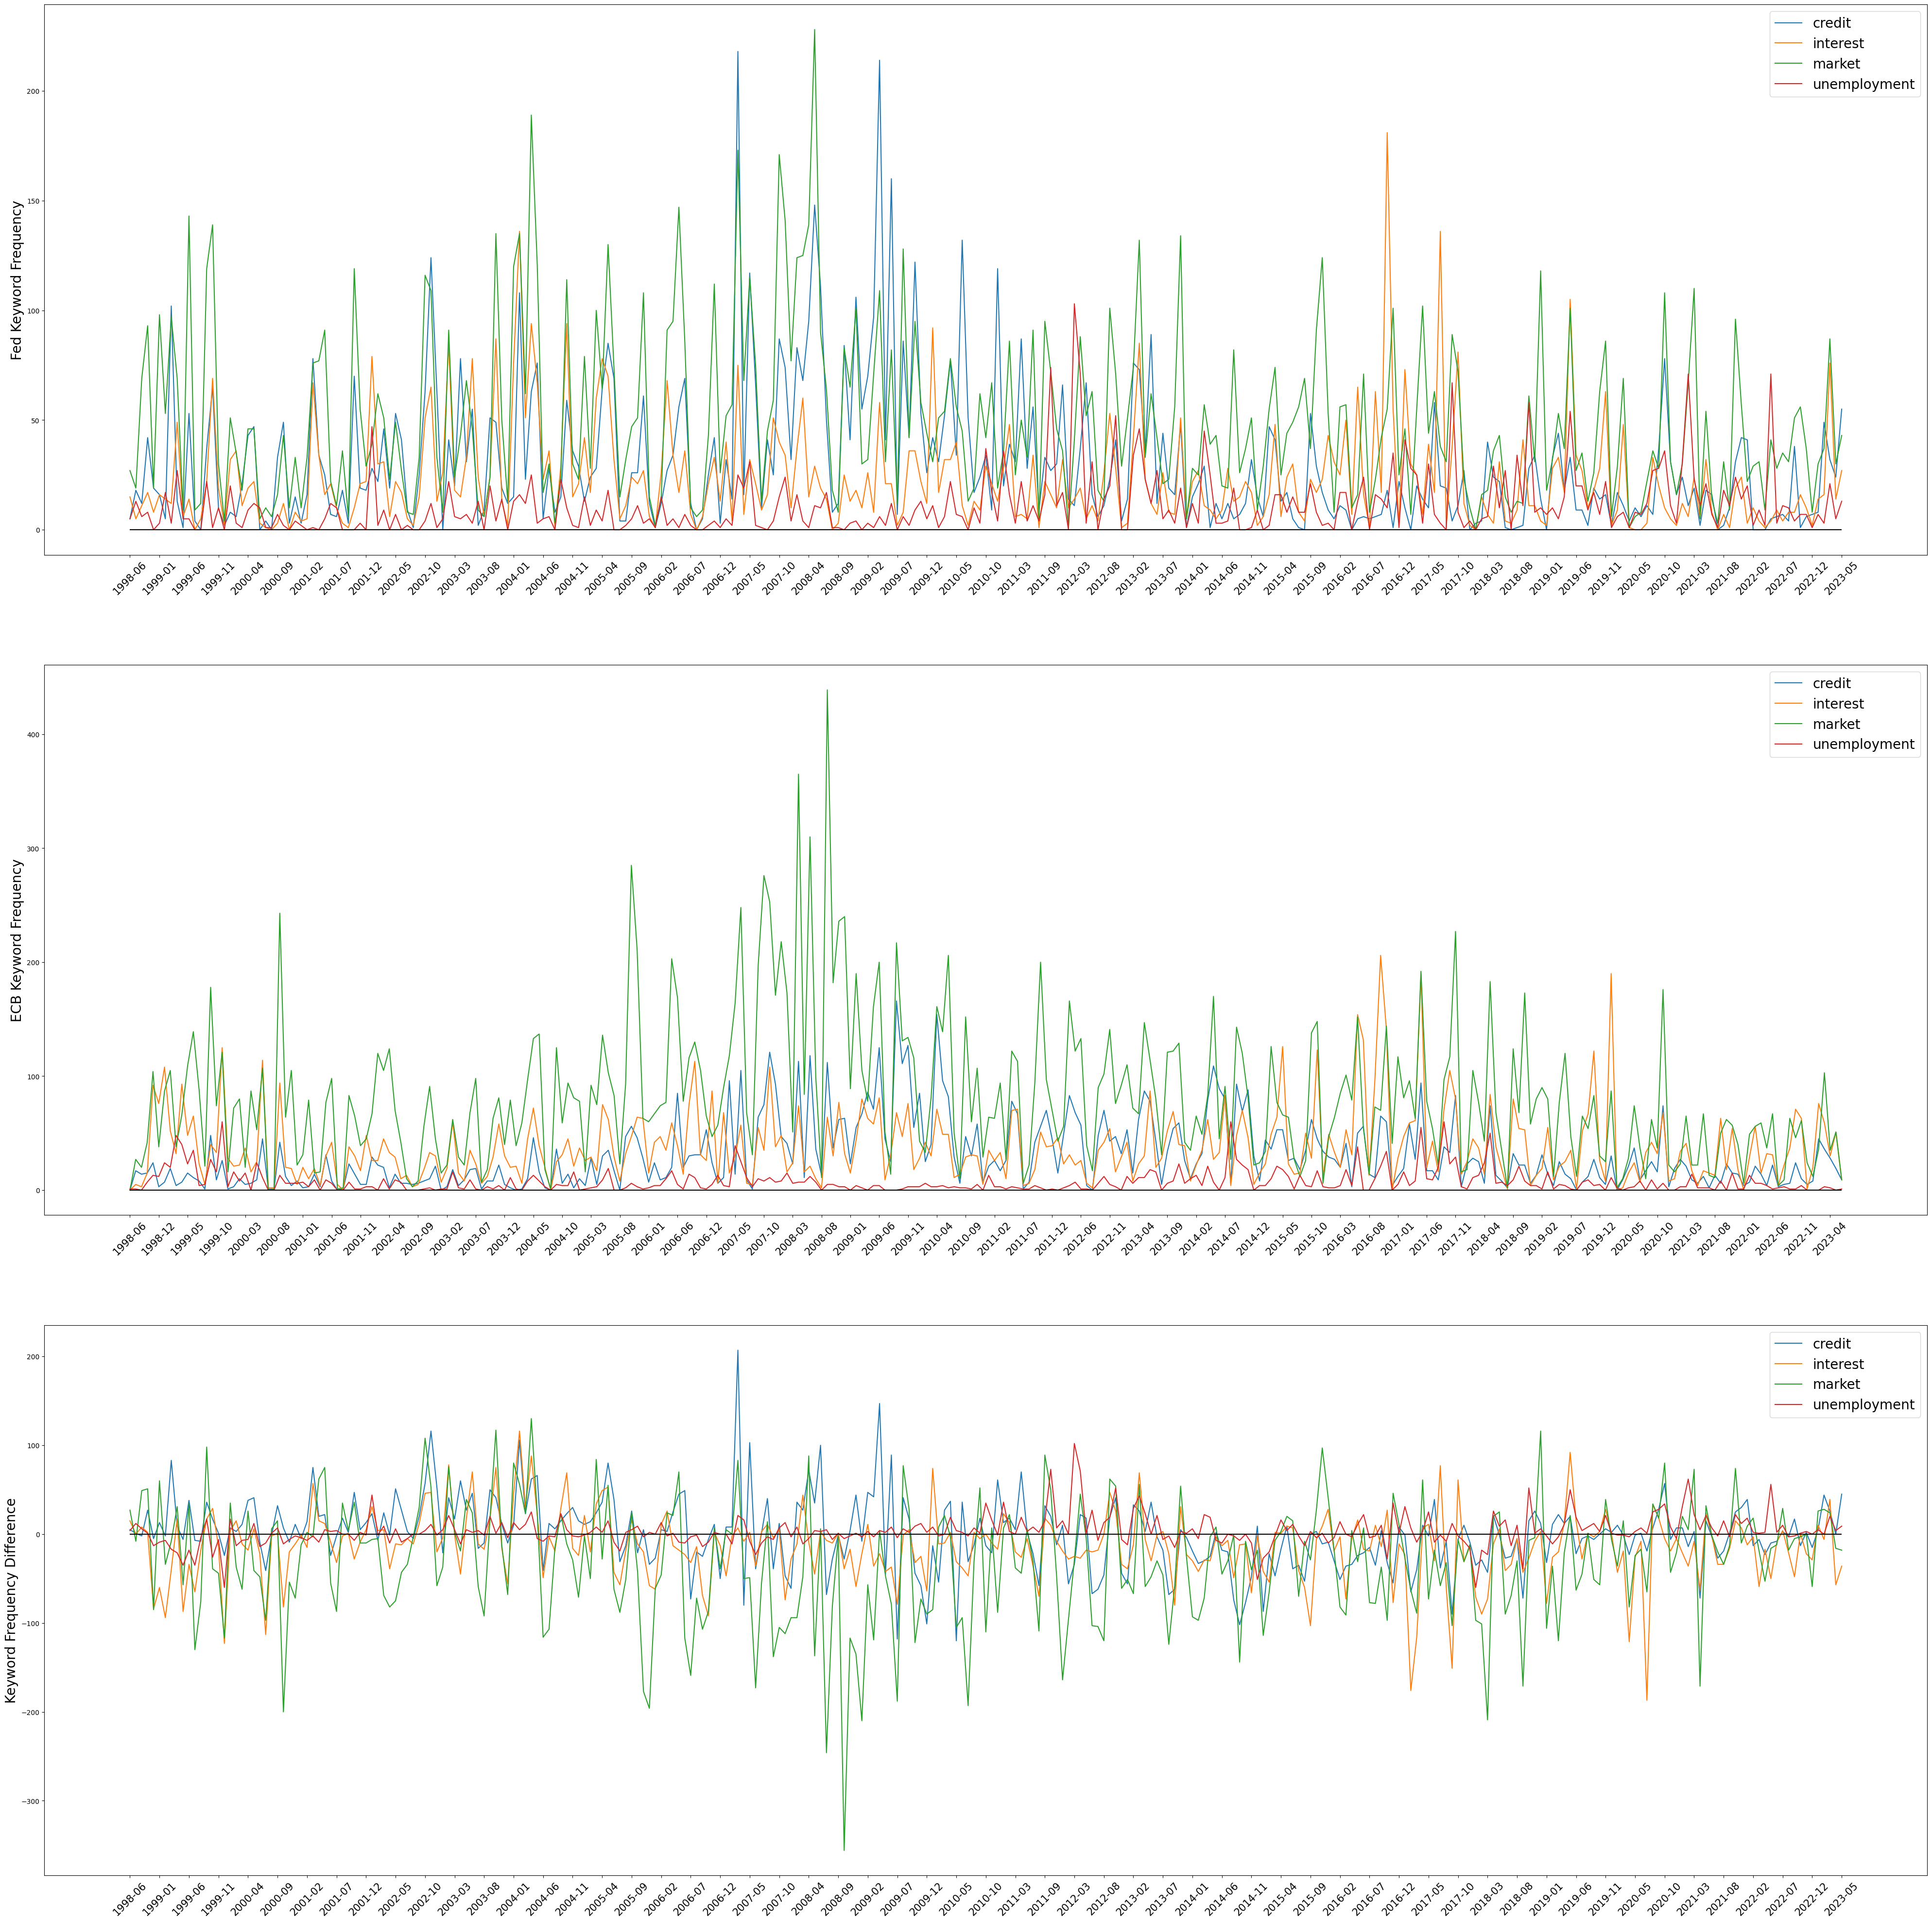

In [12]:


freq_ts_m["Year-Month"] = freq_ts_m["Year-Month"].astype(str)
freq_ts_m_2["Year-Month"] = freq_ts_m_2["Year-Month"].astype(str)
diffs["Year-Month"] = diffs["Year-Month"].astype(str)

# Create a list of x-axis tick positions
num_ticks = 50 
x_tick_positions_1 = freq_ts_m["Year-Month"].iloc[::len(freq_ts_m) // num_ticks].tolist()
x_tick_positions_2 = freq_ts_m_2["Year-Month"].iloc[::len(freq_ts_m) // num_ticks].tolist()
x_tick_positions_3 = diffs["Year-Month"].iloc[::len(freq_ts_m) // num_ticks].tolist()

y=0

fig, axs = plt.subplots(3, 1, figsize=(50, 50))

for key in keys:
    axs[0].plot(freq_ts_m["Year-Month"], freq_ts_m[f'{key}'], label=key)
    axs[1].plot(freq_ts_m_2["Year-Month"], freq_ts_m_2[f'{key}'], label=key)
    axs[2].plot(diffs["Year-Month"], diffs[f'{key}'], label=key)
    
axs[0].hlines(y, freq_ts_m["Year-Month"].min(), freq_ts_m["Year-Month"].max(), color='black')
axs[1].hlines(y, freq_ts_m_2["Year-Month"].min(), freq_ts_m_2["Year-Month"].max(), color='black')
axs[2].hlines(y, diffs["Year-Month"].min(), diffs["Year-Month"].max(), color='black')

axs[0].set_xticks(x_tick_positions_1)
axs[1].set_xticks(x_tick_positions_2)
axs[2].set_xticks(x_tick_positions_3)

axs[0].tick_params(axis='x', rotation=45, labelsize=15)
axs[1].tick_params(axis='x', rotation=45, labelsize=15)
axs[2].tick_params(axis='x', rotation=45, labelsize=15)

axs[0].set_ylabel(f'{Body} Keyword Frequency', fontsize=20)
axs[1].set_ylabel(f'{Body_2} Keyword Frequency', fontsize=20)
axs[2].set_ylabel(f'Keyword Frequency Difference', fontsize=20)

axs[0].legend(loc='upper right', fontsize=20)
axs[1].legend(loc='upper right', fontsize=20)
axs[2].legend(loc='upper right', fontsize=20)

plt.show()

In [13]:
freq_ts_m = freq_ts_m.pivot_table(index='Year-Month', columns='Keyword', values='Frequency')
print(freq_ts_m.head())

KeyError: 'Frequency'

In [ ]:
plt.figure(figsize=(10, 6))
for keyword in freq_ts_m.columns:
    plt.plot(freq_ts_m['Year-Month'].astype(str), freq_ts_m[keyword], label=keyword)

plt.xlabel('Year-Month')
plt.ylabel('Frequency')
plt.title('Frequency Over Time for Keywords')
plt.legend()

In [ ]:
gwalker = pyg.walk(freq_ts_m)

In [ ]:
freq_ts_m.columns
freq_ts_m.reset_index(inplace=True)
print(freq_ts_m.head())

In [ ]:
energy = pd.read_csv('/Users/kylenabors/Documents/Database/Other Data/Energy Prices/US Energy CPI.csv')
energy["DATE"] = pd.to_datetime(energy["DATE"]).dt.to_period('M')
freq_ts_m = freq_ts_m.merge(energy, left_on='Year-Month', right_on='DATE', how='left')
print(freq_ts_m.head())
freq_ts_m.drop(columns=['DATE'], inplace=True)

In [ ]:
funds = pd.read_excel('/Users/kylenabors/Documents/Database/Other Data/FedFundsRate.xlsx', sheet_name='Monthly')
funds['Date Adjusted'] = funds['Date Adjusted'].dt.to_period(freq='M')
freq_ts_m = freq_ts_m.merge(funds, left_on='Year-Month', right_on='Date Adjusted', how='left')

In [ ]:
cpi = pd.read_excel('/Users/kylenabors/Documents/Database/Other Data/Urban Consumer CPI.xlsx', sheet_name='Monthly')
cpi['diff'] = cpi['Value'].diff()
print(cpi.head())
cpi["Year-Month"] = pd.to_datetime(cpi["Year-Month"]).dt.to_period('M')
freq_ts_m = freq_ts_m.merge(cpi, left_on='Year-Month', right_on='Year-Month', how='left')
freq_ts_m.drop(columns=['Date Adjusted'], inplace=True)
print(freq_ts_m.head())

In [ ]:
freq_ts_m.rename(columns={'Value_x': 'Energy CPI', 'Value_y': 'Fed Funds Rate', 'Value': 'CPI'}, inplace=True)
print(freq_ts_m.head())

In [ ]:
freq_ts_m.plot(x='Year-Month', y=["decrease", "unemployment", "crisis", "negative", "downward"])

In [ ]:
gwalker = pyg.walk(freq_ts_m)